### load packages

In [1]:
import sys
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr

import matplotlib.pyplot as plt

### load data for month of choice
I created a loading file that directly loads the data files from the NYC TLC website. You can input month and year as either value types or string types. Here, we load only the `yellow` taxi data.

In [2]:
# load yellow taxi data for month 01/2023
df = pr.load_taxi_data(month = 1, year = 2023, vehicle_type = 'yellow')

In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


### initial preprocessing
Each different dataset has different column names for the column corresponding to `pickup_datetime`. For the `yellow` taxis, it is `tpep_pickup_datetime`. Let's change the name to just `pickup_datetime`. 

In [4]:
# split datetime into data and time
df.rename(
    columns = {'tpep_pickup_datetime': 'pickup_datetime',
               'tpep_dropoff_datetime': 'dropoff_datetime'}, 
    inplace = True
)

Note, this dataset contains rides occurring in dates outside of Jan. 2023. This may be data missing from older datasets that were only added later. This is something worth checking when we combine multiple datasets. For now, we just restrict this dataset to have rides in Jan. 2023.

In [5]:
print(df.pickup_datetime.sort_values().head())
print('\n ')
print('Min: ' + str(df.pickup_datetime.sort_values().min()), ', Max: ' + str(df.pickup_datetime.sort_values().max()))

2138036   2008-12-31 23:01:42
209091    2008-12-31 23:04:41
10023     2022-10-24 17:37:47
18219     2022-10-24 20:01:46
21660     2022-10-24 21:45:35
Name: pickup_datetime, dtype: datetime64[us]

 
Min: 2008-12-31 23:01:42 , Max: 2023-02-01 00:56:53


In [6]:
# remove rows with year not equal to 2023 and within January
df = df[(df.pickup_datetime.dt.year == 2023) & (df.pickup_datetime.dt.month == 1)]
df.pickup_datetime.sort_values().head()

2995098   2023-01-01 00:00:00
3497      2023-01-01 00:00:05
2506      2023-01-01 00:00:06
3499      2023-01-01 00:00:08
4475      2023-01-01 00:00:09
Name: pickup_datetime, dtype: datetime64[us]

### binning the data
Each time step in our time series will correspond to quantities from the previous hour. E.g., we will define $y_t$ to be the number of rides occurring in a given taxi zone from time $y_{t-1}$ to $y_{t}$, where $t$ is measured in hours.

For number of rides, this can be done in one line.

/tmp/ipykernel_20341/1790913425.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = df.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size()


pickup_datetime
2023-01-01 00:00:00    5336
2023-01-01 01:00:00    5752
2023-01-01 02:00:00    5097
2023-01-01 03:00:00    3952
2023-01-01 04:00:00    2501
Freq: h, dtype: int64


(464592.0, 464808.0)

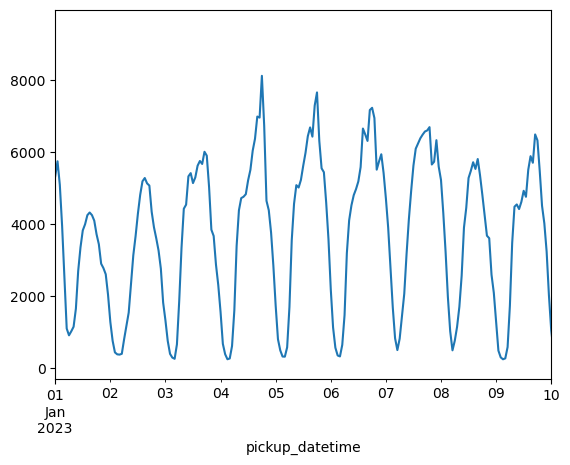

In [7]:
# convert to hourly time series
ts = df.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size()
print(ts.head())

# plot hourly time series
ts.plot()
plt.xlim('2023-01-01', '2023-01-10')

### time series for most active taxi zone

In [8]:
print(df['PULocationID'].value_counts().head())
df_132 = df[df['PULocationID'] == 132]

PULocationID
132    160024
237    148074
236    138391
161    135415
186    109226
Name: count, dtype: int64


/tmp/ipykernel_20341/1275982803.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = df_132.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size()


(464592.0, 464808.0)

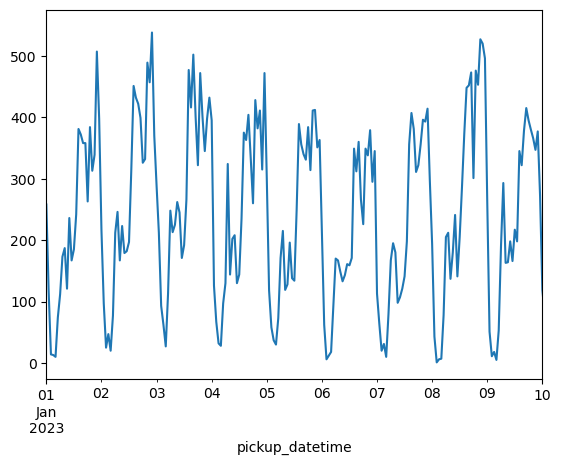

In [9]:
# convert to hourly time series
ts = df_132.set_index('pickup_datetime').groupby(pd.Grouper(freq='H')).size()
ts.head()

# plot hourly time series
ts.plot()
plt.xlim('2023-01-01', '2023-01-10')